[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Fitting 10 folds for each of 20 candidates, totalling 200 fits


2024-06-25 16:02:45.750829: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 16:02:46.454530: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14628 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2024-06-25 16:02:50.561764: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


[CV] END batch_size=32, dropout_rate=0.4, epochs=30, units=50; total time=   6.8s
[CV] END batch_size=32, dropout_rate=0.4, epochs=30, units=50; total time=   5.6s
[CV] END batch_size=32, dropout_rate=0.4, epochs=30, units=50; total time=   5.8s
[CV] END batch_size=32, dropout_rate=0.4, epochs=30, units=50; total time=   5.7s
[CV] END batch_size=32, dropout_rate=0.4, epochs=30, units=50; total time=   5.5s
[CV] END batch_size=32, dropout_rate=0.4, epochs=30, units=50; total time=   6.3s
[CV] END batch_size=32, dropout_rate=0.4, epochs=30, units=50; total time=   6.6s
[CV] END batch_size=32, dropout_rate=0.4, epochs=30, units=50; total time=   6.8s
[CV] END batch_size=32, dropout_rate=0.4, epochs=30, units=50; total time=   6.1s
[CV] END batch_size=32, dropout_rate=0.4, epochs=30, units=50; total time=   7.3s
[CV] END batch_size=64, dropout_rate=0.3, epochs=30, units=50; total time=   4.6s
[CV] END batch_size=64, dropout_rate=0.3, epochs=30, units=50; total time=   5.1s
[CV] END batch_s

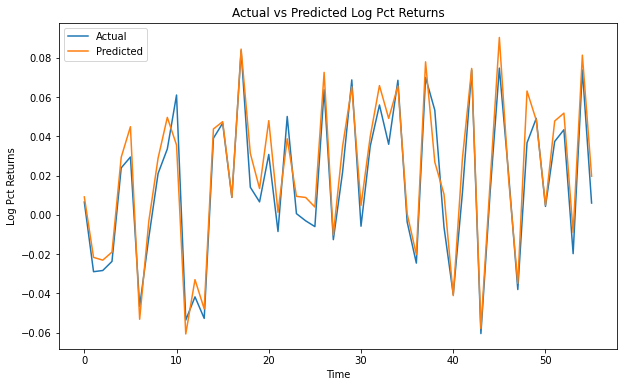

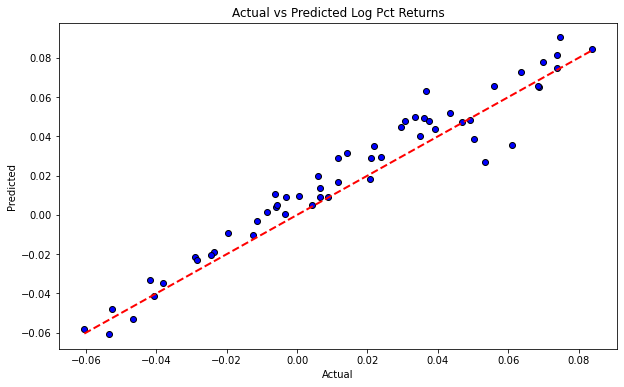

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional
from keras.wrappers.scikit_learn import KerasRegressor
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the start and end dates for data download
end_date = datetime.now()
start_date = datetime(2021, 4, 14)

# Download stock price data from Yahoo Finance using ticker 'COIN'
ticker = 'COIN'
data_coin = yf.download(tickers=ticker, start=start_date, end=end_date)
df_coin = pd.DataFrame(data_coin)
df_coin.reset_index(inplace=True)
df_coin.set_index('Date', inplace=True)

# Download gold prices and US Dollar index data from Yahoo Finance
tick_gold = 'GC=F'
tick_usindex = 'DX-Y.NYB'
data_gold = yf.download(tickers=tick_gold, start=start_date, end=end_date)
data_usindex = yf.download(tickers=tick_usindex, start=start_date, end=end_date)

# Convert downloaded data into dataframes
df_gold = pd.DataFrame(data_gold)
df_usindex = pd.DataFrame(data_usindex)

# Extract the adjusted close prices from gold and US Dollar index dataframes
df_coin['Gold_Adj_Close'] = df_gold['Adj Close']
df_coin['USIndex_Adj_Close'] = df_usindex['Adj Close']

# Forward fill missing values to align the data properly
df_coin = df_coin.ffill()

# Calculate differences between open, high, low, and adjusted close prices for the stock data
df_coin['Open_Close_Diff'] = df_coin['Open'] - df_coin['Adj Close']
df_coin['High_Low_Diff'] = df_coin['High'] - df_coin['Low']

# Calculate percentage returns and log percentage returns
df_coin['Pct_Returns'] = df_coin['Adj Close'].pct_change()
df_coin['Log_Pct_Returns'] = np.log(1 + df_coin['Pct_Returns'])
df_coin.dropna(inplace=True)

# List of columns to shift
columns_to_shift = [
    'Open', 'High', 'Adj Close', 'Low', 'Volume',
     'Open_Close_Diff', 'High_Low_Diff', 
     'Gold_Adj_Close', 'USIndex_Adj_Close'
]

# Number of lagged versions to create
num_lags = 3  

# Shift the columns
for column in columns_to_shift:
    for lag in range(1, num_lags + 1):
        df_coin[f'{column}_{lag}'] = df_coin[column].shift(lag)

df_coin['Pct_Returns_1'] = df_coin['Pct_Returns'].shift(1)
df_coin['Log_Pct_Returns_1'] = df_coin['Log_Pct_Returns'].shift(1)

df_coin.dropna(inplace=True)

# Moving Averages
# Simple Moving Averages
df_coin['SMA_5'] = df_coin['Adj Close'].rolling(window=5).mean()
df_coin['SMA_10'] = df_coin['Adj Close'].rolling(window=10).mean()
df_coin['SMA_20'] = df_coin['Adj Close'].rolling(window=20).mean()
df_coin['SMA_50'] = df_coin['Adj Close'].rolling(window=50).mean()

# Exponential Moving Averages
df_coin['EMA_50'] = df_coin['Adj Close'].ewm(span=50, adjust=False).mean()

# Relative Strength Index (RSI)
window_length = 14
delta = df_coin['Adj Close'].diff()
gain = (delta.where(delta>0, 0)).rolling(window=window_length).mean()
loss = (delta.where(delta<0, 0)).rolling(window=window_length).mean()
rs = gain/loss
df_coin['RSI'] = 100 - (100/(1+rs))

# Moving Average Convergence Divergence (MACD)
df_coin['MACD'] = df_coin['Adj Close'].ewm(span=12, adjust=False).mean() - df_coin['Adj Close'].ewm(span=26, adjust=False).mean()
df_coin['MACD_Signal'] = df_coin['MACD'].ewm(span=9, adjust=False).mean()
df_coin['MACD_Hist'] = df_coin['MACD'] - df_coin['MACD_Signal']

# Bollinger Bands
df_coin['BB_Upper'] = df_coin['SMA_20'] + 2*df_coin['Adj Close'].rolling(window=20).std()
df_coin['BB_Lower'] = df_coin['SMA_20'] - 2*df_coin['Adj Close'].rolling(window=20).std()

# Stochastic Oscillator
df_coin['14-high'] = df_coin['High'].rolling(14).max()
df_coin['14-low'] = df_coin['Low'].rolling(14).min()
df_coin['%K'] = (df_coin['Adj Close'] - df_coin['14-low']) * 100 / (df_coin['14-high'] - df_coin['14-low'])
df_coin['%D'] = df_coin['%K'].rolling(3).mean()

# Average True Range (ATR)
df_coin['H-L'] = df_coin['High'] - df_coin['Low']
df_coin['H-PC'] = np.abs(df_coin['High'] - df_coin['Adj Close'].shift(1))
df_coin['L-PC'] = np.abs(df_coin['Low'] - df_coin['Adj Close'].shift(1))
df_coin['TR'] = df_coin[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df_coin['ATR'] = df_coin['TR'].rolling(14).mean()

# List of columns to shift
columns_to_shift = [
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal', 
    'MACD_Hist', 'BB_Upper', 'BB_Lower', '%K', '%D', 'ATR'
]

# Number of lagged versions to create
num_lags = 2

# Shift the columns
for column in columns_to_shift:
    for lag in range(1, num_lags + 1):
        df_coin[f'{column}_{lag}'] = df_coin[column].shift(lag)

df_coin.dropna(inplace=True)

# Fetch economic indicators
# Fetch inflation rate data(Daily) from FRED using pandas_datareader
Inflation_df = pdr.get_data_fred('T5YIE', start=start_date, end=end_date)
Inflation_df.ffill()
Inflation_df.dropna(inplace=True)

# Fetch Federal fund rates data(Monthly) from FRED using pandas_datareader
Fedfunds_Mon = pdr.get_data_fred('FEDFUNDS', start=start_date, end=end_date)
Fedfunds_df = Fedfunds_Mon.resample('D').ffill()
Fedfunds_df.dropna(inplace=True)

# Fetch GDP growth data(Quarterly) from FRED using pandas_datareader
Gdp_Data_Quat = pdr.get_data_fred('GDPC1', start=start_date, end=end_date)
Gdp_Data_df = Gdp_Data_Quat.resample('D').ffill()
Gdp_Data_df.dropna(inplace=True)

# Fetch Unemployment rate data(Monthly) from FRED using pandas_datareader
Unemp_Data_Mon = pdr.get_data_fred('UNRATE', start=start_date, end=end_date)
Unemp_Data_df = Unemp_Data_Mon.resample('D').ffill()
Unemp_Data_df.dropna(inplace=True)

# Fetch University of Michigan Consumer Sentiment data(Monthly) from FRED using pandas_datareader
UM_Sent_Mon = pdr.get_data_fred('UMCSENT', start=start_date, end=end_date)
UM_Sent_df = UM_Sent_Mon.resample('D').ffill()
UM_Sent_df.dropna(inplace=True)

# Fetch Consumer Price Index data(Monthly) from FRED using pandas_datareader
Core_Cpi_Mon = pdr.get_data_fred('CPILFESL', start=start_date, end=end_date)
Core_Cpi_df = Core_Cpi_Mon.resample('D').ffill()
Core_Cpi_df.dropna(inplace=True)

# Fetch Commodity price data(Monthly) from FRED using pandas_datareader
Commpriceindex_Data_Mon = pdr.get_data_fred('PPIACO', start=start_date, end=end_date)
Commpriceindex_Data_df = Commpriceindex_Data_Mon.resample('D').ffill()
Commpriceindex_Data_df.dropna(inplace=True)

# Fetch M2 money supply from FRED using pandas_datareader
M2_Money_Supply_Mon = pdr.get_data_fred('WM2NS', start=start_date, end=end_date)
M2_Money_Supply_df = M2_Money_Supply_Mon.resample('D').ffill()
M2_Money_Supply_df.dropna(inplace=True)

# Setting 'Date' as index for economic data
Inflation_df.index = pd.to_datetime(Inflation_df.index)
Fedfunds_df.index = pd.to_datetime(Fedfunds_df.index)
Gdp_Data_df.index = pd.to_datetime(Gdp_Data_df.index)
Unemp_Data_df.index = pd.to_datetime(Unemp_Data_df.index)
UM_Sent_df.index = pd.to_datetime(UM_Sent_df.index)
Core_Cpi_Mon.index = pd.to_datetime(Core_Cpi_Mon.index)
Commpriceindex_Data_df.index = pd.to_datetime(Commpriceindex_Data_df.index)
M2_Money_Supply_df.index = pd.to_datetime(M2_Money_Supply_df.index)

# Merge main df with economic dataframes on 'Date'
merged_df = df_coin.join(Inflation_df, 
                    how='left').join(Fedfunds_df, 
                    how='left').join(Gdp_Data_df, 
                    how='left').join(Unemp_Data_df, 
                    how='left').join(UM_Sent_df,
                    how='left').join(Core_Cpi_df,
                    how='left').join(Commpriceindex_Data_df,
                    how='left').join(M2_Money_Supply_df,
                    how='left')
merged_df.dropna(inplace=True)

# Define the features and target variable
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1','Adj Close_1',
            'Open_Close_Diff_1','High_Low_Diff_1', 'USIndex_Adj_Close_1',
             'Open_2', 'High_2', 'Low_2','Adj Close_2',
            'Open_Close_Diff_2','USIndex_Adj_Close_2',
             'Open_3',  'Low_3',
             'USIndex_Adj_Close_3',
            'SMA_5_1', 'SMA_10_1', 'SMA_20_1',
            'EMA_50_1', 'MACD_1', 'MACD_Signal_1',
            'MACD_Hist_1', 'BB_Upper_1',  '%K_1', '%D_1','ATR_1',
            'SMA_5_2', 'SMA_10_2', 'SMA_50_2',
             'MACD_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2', 'ATR_2'
            ]
X = merged_df[features].dropna()
y = merged_df['Log_Pct_Returns_1'][X.index]

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape X_scaled for LSTM input
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Function to create the LSTM model
def create_model(units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=(X_scaled.shape[1], X_scaled.shape[2]), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(units=units)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create the model for GridSearch
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters grid
param_grid = {
    'units': [50, 100, 150],
    'dropout_rate': [0.2, 0.3, 0.4],
    'epochs': [10, 20, 30],
    'batch_size': [16, 32, 64]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=20, cv=tscv, scoring='r2', n_jobs=-1, verbose=2)

# Fit the RandomizedSearchCV
random_result = random_search.fit(X_scaled, y)

# Print the best parameters and best score
print(f"Best Parameters: {random_result.best_params_}")
print(f"Best R2 Score: {random_result.best_score_}")

# Get the best model
best_model = random_result.best_estimator_.model

# Initialize lists to store metrics
train_mse_scores = []
test_mse_scores = []
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []
train_r2_scores = []
test_r2_scores = []

# Perform cross-validation with the best model
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the best model
    best_model.fit(X_train, y_train, epochs=random_result.best_params_['epochs'], batch_size=random_result.best_params_['batch_size'], verbose=0)
    
    # Predict on the test set
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Calculate performance metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append metrics to lists
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Calculate mean and standard deviation of the scores
mean_train_mse = np.mean(train_mse_scores)
std_train_mse = np.std(train_mse_scores)
mean_test_mse = np.mean(test_mse_scores)
std_test_mse = np.std(test_mse_scores)
mean_train_rmse = np.mean(train_rmse_scores)
std_train_rmse = np.std(train_rmse_scores)
mean_test_rmse = np.mean(test_rmse_scores)
std_test_rmse = np.std(test_rmse_scores)
mean_train_mae = np.mean(train_mae_scores)
std_train_mae = np.std(train_mae_scores)
mean_test_mae = np.mean(test_mae_scores)
std_test_mae = np.std(test_mae_scores)
mean_train_r2 = np.mean(train_r2_scores)
std_train_r2 = np.std(train_r2_scores)
mean_test_r2 = np.mean(test_r2_scores)
std_test_r2 = np.std(test_r2_scores)

# Print Results
print("Training MSE: {:.4f}".format(mean_train_mse))
print("Training MSE Std Dev: {:.4f}".format(std_train_mse))
print("Test MSE: {:.4f}".format(mean_test_mse))
print("Test MSE Std Dev: {:.4f}".format(std_test_mse))
print("Training RMSE: {:.4f}".format(mean_train_rmse))
print("Training RMSE Std Dev: {:.4f}".format(std_train_rmse))
print("Test RMSE: {:.4f}".format(mean_test_rmse))
print("Test RMSE Std Dev: {:.4f}".format(std_test_rmse))
print("Training MAE: {:.4f}".format(mean_train_mae))
print("Training MAE Std Dev: {:.4f}".format(std_train_mae))
print("Test MAE: {:.4f}".format(mean_test_mae))
print("Test MAE Std Dev: {:.4f}".format(std_test_mae))
print("Training R2: {:.4f}".format(mean_train_r2))
print("Training R2 Std Dev: {:.4f}".format(std_train_r2))
print("Test R2: {:.4f}".format(mean_test_r2))
print("Test R2 Std Dev: {:.4f}".format(std_test_r2))

# Visualize model performance
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Log Pct Returns')
plt.title('Actual vs Predicted Log Pct Returns')
plt.legend()
plt.show()

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, c='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Log Pct Returns')
plt.show()


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional
from keras.wrappers.scikit_learn import KerasRegressor
import itertools
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the start and end dates for data download
end_date = datetime.now()
start_date = datetime(2021, 4, 14)

# Function to download and preprocess data for a given ticker
def download_and_preprocess_data(ticker):
    data = yf.download(tickers=ticker, start=start_date, end=end_date)
    df = pd.DataFrame(data)
    df.reset_index(inplace=True)
    df.set_index('Date', inplace=True)
    
    return df

# Download data for Coinbase, Bitcoin, and Ethereum
tickers = ['COIN', 'BTC-USD', 'ETH-USD']
dfs = {ticker: download_and_preprocess_data(ticker) for ticker in tickers}

# Download gold prices and US Dollar index data from Yahoo Finance
tick_gold = 'GC=F'
tick_usindex = 'DX-Y.NYB'
data_gold = yf.download(tickers=tick_gold, start=start_date, end=end_date)
data_usindex = yf.download(tickers=tick_usindex, start=start_date, end=end_date)

# Convert downloaded data into dataframes
df_gold = pd.DataFrame(data_gold)
df_usindex = pd.DataFrame(data_usindex)

# Add adjusted close prices for gold and US Dollar index to each asset dataframe
for df in dfs.values():
    df['Gold_Adj_Close'] = df_gold['Adj Close']
    df['USIndex_Adj_Close'] = df_usindex['Adj Close']
    df.ffill(inplace=True)

# Calculate additional features for each asset dataframe
for df in dfs.values():
    df['Open_Close_Diff'] = df['Open'] - df['Adj Close']
    df['High_Low_Diff'] = df['High'] - df['Low']
    df['Pct_Returns'] = df['Adj Close'].pct_change()
    df['Log_Pct_Returns'] = np.log(1 + df['Pct_Returns'])
    df.dropna(inplace=True)
    
    columns_to_shift = [
        'Open', 'High', 'Adj Close', 'Low', 'Volume',
        'Open_Close_Diff', 'High_Low_Diff', 
        'Gold_Adj_Close', 'USIndex_Adj_Close'
    ]
    num_lags = 3
    
    for column in columns_to_shift:
        for lag in range(1, num_lags + 1):
            df[f'{column}_{lag}'] = df[column].shift(lag)
    
    df['Pct_Returns_1'] = df['Pct_Returns'].shift(1)
    df['Log_Pct_Returns_1'] = df['Log_Pct_Returns'].shift(1)
    
    df.dropna(inplace=True)

# Download and process economic indicators
def fetch_and_preprocess_economic_data():
    # Fetch economic indicators data from FRED
    economic_indicators = {
        'T5YIE': 'Inflation',
        'FEDFUNDS': 'FedFunds',
        'GDPC1': 'GDP',
        'UNRATE': 'Unemployment',
        'UMCSENT': 'ConsumerSentiment',
        'CPILFESL': 'CoreCPI',
        'PPIACO': 'CommodityPrices',
        'WM2NS': 'M2MoneySupply'
    }
    
    dfs_economic = {}
    
    for code, name in economic_indicators.items():
        df = pdr.get_data_fred(code, start=start_date, end=end_date)
        df = df.resample('D').ffill().dropna()
        df.columns = [name]
        dfs_economic[name] = df
    
    return dfs_economic

dfs_economic = fetch_and_preprocess_economic_data()

# Merge economic data into each asset dataframe
for name, df in dfs.items():
    for econ_name, econ_df in dfs_economic.items():
        df[econ_name] = econ_df[econ_name]

# Define the features and target variable
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1','Adj Close_1',
            'Open_Close_Diff_1','High_Low_Diff_1', 'USIndex_Adj_Close_1',
            'Open_2', 'High_2', 'Low_2','Adj Close_2',
            'Open_Close_Diff_2','USIndex_Adj_Close_2',
            'Open_3',  'Low_3',
            'USIndex_Adj_Close_3',
            'SMA_5_1', 'SMA_10_1', 'SMA_20_1',
            'EMA_50_1', 'MACD_1', 'MACD_Signal_1',
            'MACD_Hist_1', 'BB_Upper_1',  '%K_1', '%D_1','ATR_1',
            'SMA_5_2', 'SMA_10_2', 'SMA_50_2',
            'MACD_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2', 'ATR_2',
            'Inflation', 'FedFunds', 'GDP', 'Unemployment', 'ConsumerSentiment', 
            'CoreCPI', 'CommodityPrices', 'M2MoneySupply'
           ]

results = {}

for name, df in dfs.items():
    X = df[features].dropna()
    y = df['Log_Pct_Returns_1'][X.index]

    # Apply MinMaxScaler
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Reshape X_scaled for LSTM input
    X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=10)

    # Function to create the LSTM model
    def create_model(units=50, dropout_rate=0.2):
        model = Sequential()
        model.add(LSTM(units=units, input_shape=(X_scaled.shape[1], X_scaled.shape[2]), return_sequences=True))
        model.add(Dropout(dropout_rate))
        model.add(Bidirectional(LSTM(units=units)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    # Create the model for GridSearch
    model = KerasRegressor(build_fn=create_model, verbose=0)

    # Define the hyperparameters grid
    param_grid = {
        'units': [50, 100, 150],
        'dropout_rate': [0.2, 0.3, 0.4],
        'epochs': [10, 20, 30],
        'batch_size': [16, 32, 64]
    }

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=20, cv=tscv, scoring='r2', n_jobs=-1, verbose=2)

    # Fit the RandomizedSearchCV
    random_result = random_search.fit(X_scaled, y)

    # Print the best parameters and best score
    print(f"{name} - Best Parameters: {random_result.best_params_}")
    print(f"{name} - Best R2 Score: {random_result.best_score_}")

    # Get the best model
    best_model = random_result.best_estimator_.model

    # Initialize lists to store metrics
    train_mse_scores = []
    test_mse_scores = []
    train_rmse_scores = []
    test_rmse_scores = []
    train_mae_scores = []
    test_mae_scores = []
    train_r2_scores = []
    test_r2_scores = []

    # Perform cross-validation with the best model
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the best model
        best_model.fit(X_train, y_train, epochs=random_result.best_params_['epochs'], batch_size=random_result.best_params_['batch_size'], verbose=0)

        # Predict on the test set
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        # Calculate performance metrics
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_rmse = np.sqrt(train_mse)
        test_rmse = np.sqrt(test_mse)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        # Append metrics to lists
        train_mse_scores.append(train_mse)
        test_mse_scores.append(test_mse)
        train_rmse_scores.append(train_rmse)
        test_rmse_scores.append(test_rmse)
        train_mae_scores.append(train_mae)
        test_mae_scores.append(test_mae)
        train_r2_scores.append(train_r2)
        test_r2_scores.append(test_r2)

    # Calculate mean and standard deviation of the scores
    mean_train_mse = np.mean(train_mse_scores)
    std_train_mse = np.std(train_mse_scores)
    mean_test_mse = np.mean(test_mse_scores)
    std_test_mse = np.std(test_mse_scores)
    mean_train_rmse = np.mean(train_rmse_scores)
    std_train_rmse = np.std(train_rmse_scores)
    mean_test_rmse = np.mean(test_rmse_scores)
    std_test_rmse = np.std(test_rmse_scores)
    mean_train_mae = np.mean(train_mae_scores)
    std_train_mae = np.std(train_mae_scores)
    mean_test_mae = np.mean(test_mae_scores)
    std_test_mae = np.std(test_mae_scores)
    mean_train_r2 = np.mean(train_r2_scores)
    std_train_r2 = np.std(train_r2_scores)
    mean_test_r2 = np.mean(test_r2_scores)
    std_test_r2 = np.std(test_r2_scores)

    # Print Results
    print(f"{name} - Training MSE: {:.4f}".format(mean_train_mse))
    print(f"{name} - Training MSE Std Dev: {:.4f}".format(std_train_mse))
    print(f"{name} - Test MSE: {:.4f}".format(mean_test_mse))
    print(f"{name} - Test MSE Std Dev: {:.4f}".format(std_test_mse))
    print(f"{name} - Training RMSE: {:.4f}".format(mean_train_rmse))
    print(f"{name} - Training RMSE Std Dev: {:.4f}".format(std_train_rmse))
    print(f"{name} - Test RMSE: {:.4f}".format(mean_test_rmse))
    print(f"{name} - Test RMSE Std Dev: {:.4f}".format(std_test_rmse))
    print(f"{name} - Training MAE: {:.4f}".format(mean_train_mae))
    print(f"{name} - Training MAE Std Dev: {:.4f}".format(std_train_mae))
    print(f"{name} - Test MAE: {:.4f}".format(mean_test_mae))
    print(f"{name} - Test MAE Std Dev: {:.4f}".format(std_test_mae))
    print(f"{name} - Training R2: {:.4f}".format(mean_train_r2))
    print(f"{name} - Training R2 Std Dev: {:.4f}".format(std_train_r2))
    print(f"{name} - Test R2: {:.4f}".format(mean_test_r2))
    print(f"{name} - Test R2 Std Dev: {:.4f}".format(std_test_r2))

    # Store results
    results[name] = {
        'mean_train_mse': mean_train_mse,
        'std_train_mse': std_train_mse,
        'mean_test_mse': mean_test_mse,
        'std_test_mse': std_test_mse,
        'mean_train_rmse': mean_train_rmse,
        'std_train_rmse': std_train_rmse,
        'mean_test_rmse': mean_test_rmse,
        'std_test_rmse': std_test_rmse,
        'mean_train_mae': mean_train_mae,
        'std_train_mae': std_train_mae,
        'mean_test_mae': mean_test_mae,
        'std_test_mae': std_test_mae,
        'mean_train_r2': mean_train_r2,
        'std_train_r2': std_train_r2,
        'mean_test_r2': mean_test_r2,
        'std_test_r2': std_test_r2
    }

    # Visualize model performance
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_test_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Log Pct Returns')
    plt.title(f'Actual vs Predicted Log Pct Returns for {name}')
    plt.legend()
    plt.show()

    # Residual plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, c='blue', edgecolor='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted Log Pct Returns for {name}')
    plt.show()


SyntaxError: f-string: empty expression not allowed (4096861354.py, line 236)